In Deep learning, data augmentation techniques and transforms are essential to improve the quality and quantity of data used to train models. In the case of the CIFAR10 dataset, which consists of 60,000 color images of 32x32 pixels, these techniques are particularly important.

To augment the data, we use two techniques - Random Crop and Random Horizontal Flip. Random Crop selects a random subset of the original image, while Random Horizontal Flip flips an image horizontally with a certain probability. Both of these techniques help to introduce variations in the dataset, making the model more capable of recognizing similar images with different compositions.

After applying the data augmentation techniques, we use the To Tensor transform, which converts the images into PyTorch tensors and scales them by 255. This transformation is essential because PyTorch works with tensors, and scaling the images helps to normalize the pixel values.

Lastly, we apply the Normalize transform to adjust the mean and standard deviation of the image pixels, making the images more standardized. The values of the pixels become 0.0 and 1.0, respectively.

To ensure consistency and reproducibility, we download the CIFAR10 dataset in the root directory ./data and set PyTorch's random number generator to a seed value of 17. By doing this, we get the same validation set each time, which helps us to evaluate the model's performance accurately.

Overall, applying data augmentation techniques and transforms to the CIFAR10 dataset helps to improve the quality of the data and enhance the model's performance. These techniques can also be applied to other datasets, making it an essential part of machine learning workflows.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import multiprocessing
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader
import torch
torch.manual_seed(17)

from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

class FetchDataset:

    def __init__(self, dataset="CIFAR10", batch_size=64):
        print("Initializing fetching %s dataset using torchvision"%(dataset))
        # check if the dataset exists in torchvision
        self.datasetObject = torchvision.datasets.__dict__.get(dataset, None)
        if self.datasetObject == None:
            raise Exception("Dataset %s not available in torchvision."%(dataset))
        self.batch_size = batch_size
        self.transformers_training = []
        self.transformers_testing = []
        # set number of workers available for multiprocessing
        self.workersAvailable = min(multiprocessing.cpu_count(), 14)
      
    def dataAugmentation(self, size=32, padding=3):
        # add data augmentation transforms to the training set
        self.transformers_training.append(transforms.RandomHorizontalFlip())
        self.transformers_training.append(transforms.RandomCrop(size=size, padding=padding))
        self.transformers_training.append(transforms.functional.equalize)
        self.transformers_testing.append(transforms.functional.equalize)

    def __addToTensor(self):
        # add ToTensor transform to the training and testing sets
        self.transformers_training.append(transforms.ToTensor())
        self.transformers_testing.append(transforms.ToTensor())

    def addNormalizer(self):
        self.__addToTensor()
        # load training set to compute mean and standard deviation
        dataset_training = self.datasetObject(root="./data", train=True, download=True)
        data_train = dataset_training.data/255.0
        mean = data_train.mean(axis=(0, 1, 2))
        std = data_train.std(axis=(0, 1, 2))
        # add Normalize transform to the training and testing sets
        self.transformers_training.append(transforms.Normalize(mean=mean, std=std))
        self.transformers_testing.append(transforms.Normalize(mean=mean, std=std))
        

    def getLoaders(self):
        if len(self.transformers_training) == 0:
            self.__addToTensor()
        # create data loaders with the defined batch size, transformers and number of workers
        dataset_training = self.datasetObject(root="./data", train=True, download=True, transform=transforms.Compose(self.transformers_training))
        dataset_testing = self.datasetObject(root="./data", train=False, download=True, transform=transforms.Compose(self.transformers_testing))
        load_train = DataLoader(dataset_training, batch_size=self.batch_size, shuffle=True, num_workers=self.workersAvailable)
        load_test = DataLoader(dataset_testing, batch_size=self.batch_size, shuffle=False, num_workers=self.workersAvailable)
        # return the training and testing data loaders
        return load_train, load_test
    

# create a new instance of FetchDataset for the CIFAR10 dataset with batch size of 128
df = FetchDataset(dataset="CIFAR10", batch_size=128)
# add data augmentation transforms to the training set with size 32 and padding 4
df.dataAugmentation(size=32, padding=4)
# add normalizing transforms to the training and testing sets
df.addNormalizer()
# get the training and testing data loaders
trainLoader, testLoader = df.getLoaders()

Initializing fetching CIFAR10 dataset using torchvision


100%|██████████| 170498071/170498071 [00:05<00:00, 29108490.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Modified the basic resnet model from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py 

• Ci, the number of channels in the ith layer.
• Fi, the filter size in the ith layer
• Ki, the kernel size in the ith skip connection
• P, the pool size in the average pool layer

Using the following values for the Hyperparameters (design variables) in our architectures : 

    C=[64,128,128,256]
    F=[3,3,3,3]
    K=[1,1,1,1]  
    P=4



In [ ]:
# Import necessary PyTorch modules
import torch.nn as nn
import torch.nn.functional as F

# Define the BasicBlock class, which is used to construct the layers in the ResNet architecture
class BasicBlock(nn.Module):

    # Initialize the BasicBlock class
    def __init__(self, in_planes, planes, kernel_size, skip_kernel, stride=1):
        super(BasicBlock, self).__init__()

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # Define the shortcut connection, which is used to add the output of the convolutional layers to the input
        self.shortcut = nn.Sequential()

        # If the stride is not 1 or the number of input planes is not equal to the number of output planes, 
        # define a convolutional layer and a batch normalization layer for the shortcut connection
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=skip_kernel, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    # Define the forward pass for the BasicBlock class
    def forward(self, x):
        # Apply the first convolutional layer, batch normalization, and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))

        # Apply the second convolutional layer and batch normalization
        out = self.bn2(self.conv2(out))

        # Add the shortcut connection to the output of the convolutional layers
        out += self.shortcut(x)

        # Apply the ReLU activation
        out = F.relu(out)

        return out

# Define the ResNet class, which is used to construct the ResNet architecture
class ResNet(nn.Module):

    # Initialize the ResNet class
    def __init__(self,N:int, B:list, C:list, F:list, K:list, P:int, num_classes=10):
        super(ResNet, self).__init__()

        # Initialize the number of input planes
        self.in_planes = C[0]

        # Set the block to the BasicBlock class
        self.block = BasicBlock

        # Store the values of N, B, C, F, K, and P
        self.N, self.B, self.C, self.F, self.K, self.P= N, B, C, F, K, P

        # Initialize a container for the layers
        self.layers = []

        # Set the stride for each layer
        self.S = [2] * N
        self.S[0] = 1

        # Calculate the input dimension for the output linear layer
        self.outLayerInSize = C[N-1]*(32//(P*2**(N-1)))*(32//(P*2**(N-1)))

        # Print Model Config
        print("\n\nModel Config: "
            "\n-------------------------------------"
            "\nN (# Layers)\t:",self.N,
            "\nB (# Blocks)\t:",self.B,
            "\nC (# Channels)\t:",C,
            "\nF (Conv Kernel)\t:",F,
            "\nK (Skip Kernel)\t:",K,
            "\nP (Pool Kernel)\t:",P,)

        # Define the first convolution layer with 3 input channels, C[0] output channels, F[0] kernel size,
        # stride of 1, padding of 1, and no bias
        self.conv1 = nn.Conv2d(3, C[0], kernel_size=F[0], stride=1, padding=1, bias=False)
        # Define a batch normalization layer with C[0] channels
        self.bn1 = nn.BatchNorm2d(C[0])
        
        # Define N residual blocks
        for i in range(N): 
          # Dynamically create variable names for each residual block using the exec() function
            exec("self.layer{} = self._make_layer(self.block, self.C[{}], self.B[{}], self.F[{}], self.K[{}], self.S[{}])"\
                .format(i+1,i,i,i,i,i))
            # Append the residual block to the layers ModuleList
            exec("self.layers.append(self.layer{})".format(i+1))
            # Define the final linear layer with input size of outLayerInSize and output size of num_classes
        self.linear = nn.Linear(self.outLayerInSize, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, kernel_size, skip_kernel, stride):
      # Set stride for each block in the layer
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, kernel_size, skip_kernel, stride)) # Append each block to the layer with given arguments
            self.in_planes = planes  # Update the number of input planes for the next block
        return nn.Sequential(*layers)  # Return a sequential module containing all the blocks in the layer

    def forward(self, x):
        # Apply the first convolutional layer followed by batch normalization and ReLU activation
        out = F.relu(self.bn1(self.conv1(x)))
        # Apply all the blocks in the layer
        for layer in self.layers:
            out = layer(out)
        out = F.avg_pool2d(out, self.P) # Apply average pooling with kernel size self.P
        out = out.view(out.size(0), -1)  # Flatten the output tensor
        out = self.linear(out)  # Apply the fully connected linear layer
        return out # Return the final output

def resnet_model():
# Define the parameters for the ResNet architecture
    B=[3,3,2,3]  # number of blocks in each layer
    C=[64,128,128,256]  # number of output channels in each layer
    F=[3,3,3,3]  # kernel size for each layer
    K=[1,1,1,1] # skip kernel size for each layer
    P=4       # average pooling kernel size
    N=len(B)  # number of layers in the network
# Return a new ResNet model with the defined parameters
    return ResNet(N, B, C, F, K, P)



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model = resnet_model()
model = model.to(device)



Model Config: 
-------------------------------------
N (# Layers)	: 4 
B (# Blocks)	: [3, 3, 2, 3] 
C (# Channels)	: [64, 128, 128, 256] 
F (Conv Kernel)	: [3, 3, 3, 3] 
K (Skip Kernel)	: [1, 1, 1, 1] 
P (Pool Kernel)	: 4


We run our model for 300 epochs, to find out the best possible accuracy. The accuracy becomes near about constant after it. We define our:

learning rate, weightDecay, type of optimizer to be used (we tried with Adam, Adagrad, AdaDelta), with Adadelta giving out the best accuracy.

The scheduler set the learning rate of each parameter group using a cosine annealing schedule


###**ADAM Optimizer**

In [ ]:
EPOCHS=300
globalBestAccuracy = 0.0
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

loss_function = torch.nn.CrossEntropyLoss(reduction='sum')
learningRate = 0.001
weightDecay = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=learningRate/10.0)
print(model.eval())
trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters : %s"%(trainable_parameters))
if trainable_parameters > 5*(10**6):
    raise Exception("Model not under budget!")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

Model Training and Testing.
Here we are training our model over 300 epochs and trying to find out the best accuracy our model provides for the CIFAR dataset.

In [ ]:
def train(model,loader, optimizer): # Define the function to train the model and return the updated model and optimizer
    model.train()                   # Set the model to train mode
    optimizer.zero_grad()            # Clear the gradients of the optimizer
    return model, optimizer         # Return the updated model and optimizer

def test(model,loader):          # Define the function to evaluate the model on the test set
    return model.eval()          # Set the model to evaluation mode

def getLoss(loader,model,optimizer):        # Define the function to calculate the loss and accuracy for a given loader and model
    running_loss = 0.0                      # Initialize the running loss and correct count
    running_correct = 0
    for images, labels in loader:            # Iterate through the loader
        images = images.to(device)           # Move the images and labels to the device
        labels = labels.to(device)
        output = model(images)               # Forward pass
        loss = loss_function(output, labels) # Calculate the loss
        predicted_labels = torch.argmax(output, dim=1)  # Calculate the predicted labels
        running_loss += loss.item()    # Update the running loss and correct count
        running_correct += torch.sum(predicted_labels == labels).float().item()
        if phase == "train":           # If the phase is "train", backpropagate the loss and update the optimizer
            loss.backward()
            optimizer.step()
    return running_loss,running_correct


In [ ]:
for i in tqdm(range(EPOCHS)):        # Iterate through the epochs
    for phase in ['train', 'test']:   # Iterate through the phases (train and test)
        if phase == "train":          # If the phase is "train", set the loader and call the train function
            loader = trainLoader
            model,optimzier= train(model,loader,optimizer)
        else:                      # If the phase is "test", set the loader and call the test function
            loader = testLoader
            model=test(model,loader)
        running_loss,running_correct = getLoss(loader,model,optimizer)
        epoch_loss = running_loss/len(loader.dataset)      # Calculate the epoch loss and accuracy
        epoch_acc = running_correct/len(loader.dataset)
        if phase == "train":          # If the phase is "train", update the scheduler and append the results to the train lists
            scheduler.step()
            train_loss.append(epoch_loss)
            train_accuracy.append(epoch_acc)
        else:                         # If the phase is "test", append the results to the test lists and update the global best accuracy
            test_loss.append(epoch_loss)
            test_accuracy.append(epoch_acc)
            globalBestAccuracy = max(globalBestAccuracy, epoch_acc) 

        torch.save({
                    'epoch': i,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_accuracy': train_accuracy,
                    'test_accuracy': test_accuracy,
                    }, '/content/gdrive/MyDrive/model2.pt')

    print("Training Loss : %s, Testing Loss : %s, Training Accuracy : %s, Testing Accuracy : %s"\
          %(train_loss[-1], test_loss[-1], train_accuracy[-1], test_accuracy[-1]))

  0%|          | 1/300 [00:59<4:56:03, 59.41s/it]

Training Loss : 3.040477334899902, Testing Loss : 2.3654392826080324, Training Accuracy : 0.10874, Testing Accuracy : 0.102


  1%|          | 2/300 [01:51<4:32:19, 54.83s/it]

Training Loss : 2.3038612701416015, Testing Loss : 2.2989723239898683, Training Accuracy : 0.10228, Testing Accuracy : 0.1072


  1%|          | 3/300 [02:42<4:24:34, 53.45s/it]

Training Loss : 2.293503948059082, Testing Loss : 2.2840940391540525, Training Accuracy : 0.1086, Testing Accuracy : 0.1369


  1%|▏         | 4/300 [03:34<4:21:03, 52.92s/it]

Training Loss : 2.267441561279297, Testing Loss : 2.217975033569336, Training Accuracy : 0.13878, Testing Accuracy : 0.1644


  2%|▏         | 5/300 [04:25<4:16:52, 52.24s/it]

Training Loss : 2.2086803552246095, Testing Loss : 2.21544686088562, Training Accuracy : 0.16682, Testing Accuracy : 0.1813


  2%|▏         | 6/300 [05:18<4:16:31, 52.35s/it]

Training Loss : 2.178263030090332, Testing Loss : 2.1646126220703126, Training Accuracy : 0.17864, Testing Accuracy : 0.1919


  2%|▏         | 7/300 [06:11<4:16:12, 52.47s/it]

Training Loss : 2.1224982446289062, Testing Loss : 2.0741688999176024, Training Accuracy : 0.2058, Testing Accuracy : 0.2218


  3%|▎         | 8/300 [07:02<4:13:05, 52.00s/it]

Training Loss : 2.066834791564941, Testing Loss : 2.10957873840332, Training Accuracy : 0.22902, Testing Accuracy : 0.2183


  3%|▎         | 9/300 [07:54<4:12:12, 52.00s/it]

Training Loss : 2.0495605657958986, Testing Loss : 2.0470040449142455, Training Accuracy : 0.22436, Testing Accuracy : 0.2339


  3%|▎         | 10/300 [08:47<4:12:31, 52.25s/it]

Training Loss : 1.9869314395141602, Testing Loss : 1.9861693307876587, Training Accuracy : 0.25748, Testing Accuracy : 0.286


  4%|▎         | 11/300 [09:38<4:09:52, 51.88s/it]

Training Loss : 1.9153333166503905, Testing Loss : 1.9111702453613282, Training Accuracy : 0.2915, Testing Accuracy : 0.293


  4%|▍         | 12/300 [10:30<4:09:55, 52.07s/it]

Training Loss : 1.8301637860107423, Testing Loss : 1.8105827753067016, Training Accuracy : 0.32954, Testing Accuracy : 0.3355


  4%|▍         | 13/300 [11:23<4:10:15, 52.32s/it]

Training Loss : 1.9262871551513672, Testing Loss : 2.0820013282775878, Training Accuracy : 0.2946, Testing Accuracy : 0.2522


  5%|▍         | 14/300 [12:14<4:07:43, 51.97s/it]

Training Loss : 1.8249395672607422, Testing Loss : 1.7500729038238525, Training Accuracy : 0.33462, Testing Accuracy : 0.3584


  5%|▌         | 15/300 [13:06<4:07:13, 52.05s/it]

Training Loss : 1.7172845196533204, Testing Loss : 1.6869613286972045, Training Accuracy : 0.37238, Testing Accuracy : 0.3838


  5%|▌         | 16/300 [13:58<4:06:05, 51.99s/it]

Training Loss : 1.6171406977844238, Testing Loss : 1.63085269241333, Training Accuracy : 0.41228, Testing Accuracy : 0.4093


  6%|▌         | 17/300 [14:50<4:05:10, 51.98s/it]

Training Loss : 1.6081773406982423, Testing Loss : 1.6490357036590577, Training Accuracy : 0.4124, Testing Accuracy : 0.3895


  6%|▌         | 18/300 [15:43<4:05:35, 52.25s/it]

Training Loss : 1.528115509338379, Testing Loss : 1.6355360820770264, Training Accuracy : 0.44322, Testing Accuracy : 0.4114


  6%|▋         | 19/300 [16:36<4:05:05, 52.33s/it]

Training Loss : 1.52790111328125, Testing Loss : 1.592645585823059, Training Accuracy : 0.44734, Testing Accuracy : 0.4079


  7%|▋         | 20/300 [17:27<4:03:06, 52.09s/it]

Training Loss : 1.4567992202758788, Testing Loss : 1.4529387903213502, Training Accuracy : 0.47216, Testing Accuracy : 0.4817


  7%|▋         | 21/300 [18:19<4:02:29, 52.15s/it]

Training Loss : 1.3632754580688478, Testing Loss : 1.4219790185928345, Training Accuracy : 0.50566, Testing Accuracy : 0.4714


  7%|▋         | 22/300 [19:12<4:01:45, 52.18s/it]

Training Loss : 1.33311150390625, Testing Loss : 1.3663141510009766, Training Accuracy : 0.51778, Testing Accuracy : 0.5245


  8%|▊         | 23/300 [20:03<3:59:09, 51.80s/it]

Training Loss : 1.2716945362854004, Testing Loss : 1.3872776012420653, Training Accuracy : 0.53774, Testing Accuracy : 0.5113


  8%|▊         | 24/300 [20:55<3:59:24, 52.05s/it]

Training Loss : 1.3157277365112305, Testing Loss : 1.5145623401641846, Training Accuracy : 0.52526, Testing Accuracy : 0.4794


  8%|▊         | 25/300 [21:48<3:59:14, 52.20s/it]

Training Loss : 1.2927462673950196, Testing Loss : 1.4418871723175049, Training Accuracy : 0.53424, Testing Accuracy : 0.4872


  9%|▊         | 26/300 [22:39<3:57:16, 51.96s/it]

Training Loss : 1.232786886291504, Testing Loss : 1.2121151950836182, Training Accuracy : 0.55962, Testing Accuracy : 0.5734


  9%|▉         | 27/300 [23:32<3:57:08, 52.12s/it]

Training Loss : 1.1657681312561035, Testing Loss : 1.2306890056610107, Training Accuracy : 0.57774, Testing Accuracy : 0.5551


  9%|▉         | 28/300 [24:24<3:56:50, 52.25s/it]

Training Loss : 1.136023704071045, Testing Loss : 1.2152677713394164, Training Accuracy : 0.59078, Testing Accuracy : 0.5739


 10%|▉         | 29/300 [25:16<3:55:09, 52.06s/it]

Training Loss : 1.11293922164917, Testing Loss : 1.1332134756088257, Training Accuracy : 0.60318, Testing Accuracy : 0.5964


 10%|█         | 30/300 [26:09<3:55:25, 52.32s/it]

Training Loss : 1.042664870300293, Testing Loss : 1.1570975610733032, Training Accuracy : 0.62698, Testing Accuracy : 0.5981


 10%|█         | 31/300 [27:00<3:53:27, 52.07s/it]

Training Loss : 1.057642749938965, Testing Loss : 1.1831123032569886, Training Accuracy : 0.62474, Testing Accuracy : 0.5834


 11%|█         | 32/300 [27:52<3:52:13, 51.99s/it]

Training Loss : 1.0929962100219726, Testing Loss : 1.2954337413787842, Training Accuracy : 0.61168, Testing Accuracy : 0.5665


 11%|█         | 33/300 [28:45<3:52:37, 52.27s/it]

Training Loss : 1.0644264453125, Testing Loss : 1.1090251737594605, Training Accuracy : 0.62326, Testing Accuracy : 0.6171


 11%|█▏        | 34/300 [29:37<3:51:47, 52.28s/it]

Training Loss : 0.9608574070739746, Testing Loss : 1.027026951599121, Training Accuracy : 0.65876, Testing Accuracy : 0.6387


 12%|█▏        | 35/300 [30:29<3:49:47, 52.03s/it]

Training Loss : 0.9521490635681152, Testing Loss : 1.0161861503601075, Training Accuracy : 0.66856, Testing Accuracy : 0.6494


 12%|█▏        | 36/300 [31:22<3:49:57, 52.27s/it]

Training Loss : 0.9237684713745117, Testing Loss : 0.9885845622062683, Training Accuracy : 0.67818, Testing Accuracy : 0.6563


 12%|█▏        | 37/300 [32:15<3:50:00, 52.47s/it]

Training Loss : 0.8849657557678222, Testing Loss : 1.0059080806732177, Training Accuracy : 0.69442, Testing Accuracy : 0.6584


 13%|█▎        | 38/300 [33:06<3:47:47, 52.17s/it]

Training Loss : 0.9006251690673828, Testing Loss : 1.0567565240859986, Training Accuracy : 0.6847, Testing Accuracy : 0.6507


 13%|█▎        | 39/300 [33:58<3:47:05, 52.21s/it]

Training Loss : 0.8648384266662598, Testing Loss : 0.9309069948196411, Training Accuracy : 0.69944, Testing Accuracy : 0.676


 13%|█▎        | 40/300 [34:51<3:47:16, 52.45s/it]

Training Loss : 0.8283550094604493, Testing Loss : 0.9778568189620972, Training Accuracy : 0.7124, Testing Accuracy : 0.6723


 14%|█▎        | 41/300 [35:42<3:44:23, 51.98s/it]

Training Loss : 0.8136877059936524, Testing Loss : 0.9123391713142395, Training Accuracy : 0.7171, Testing Accuracy : 0.6911


 14%|█▍        | 42/300 [36:34<3:43:38, 52.01s/it]

Training Loss : 0.7901667227172852, Testing Loss : 0.9456481977462768, Training Accuracy : 0.72902, Testing Accuracy : 0.6794


 14%|█▍        | 43/300 [37:27<3:44:06, 52.32s/it]

Training Loss : 0.7864564428710937, Testing Loss : 0.8623360485076904, Training Accuracy : 0.72858, Testing Accuracy : 0.7087


 15%|█▍        | 44/300 [38:19<3:42:02, 52.04s/it]

Training Loss : 0.7377571859741211, Testing Loss : 0.8763502285003663, Training Accuracy : 0.74844, Testing Accuracy : 0.7082


 15%|█▌        | 45/300 [39:11<3:41:05, 52.02s/it]

Training Loss : 0.7591000415039062, Testing Loss : 0.891659614276886, Training Accuracy : 0.73796, Testing Accuracy : 0.7019


 15%|█▌        | 46/300 [40:04<3:41:20, 52.28s/it]

Training Loss : 0.7577508746337891, Testing Loss : 0.9109302216529847, Training Accuracy : 0.73886, Testing Accuracy : 0.7017


 16%|█▌        | 47/300 [40:55<3:39:05, 51.96s/it]

Training Loss : 0.7201833734130859, Testing Loss : 0.7841699857711792, Training Accuracy : 0.75094, Testing Accuracy : 0.7298


 16%|█▌        | 48/300 [41:47<3:38:48, 52.10s/it]

Training Loss : 0.6817779058074951, Testing Loss : 0.7977500310897827, Training Accuracy : 0.76844, Testing Accuracy : 0.7382


 16%|█▋        | 49/300 [42:40<3:38:59, 52.35s/it]

Training Loss : 0.6627466999053955, Testing Loss : 0.8881770483016967, Training Accuracy : 0.7706, Testing Accuracy : 0.7062


 17%|█▋        | 50/300 [43:31<3:36:30, 51.96s/it]

Training Loss : 0.6565868521881103, Testing Loss : 0.7636564882278443, Training Accuracy : 0.77342, Testing Accuracy : 0.7466


 17%|█▋        | 51/300 [44:23<3:35:37, 51.96s/it]

Training Loss : 0.6365746844482422, Testing Loss : 0.7550782583236695, Training Accuracy : 0.78142, Testing Accuracy : 0.75


 17%|█▋        | 52/300 [45:16<3:36:10, 52.30s/it]

Training Loss : 0.6199806398010254, Testing Loss : 0.7776124447822571, Training Accuracy : 0.78574, Testing Accuracy : 0.7404


 18%|█▊        | 53/300 [46:07<3:33:38, 51.90s/it]

Training Loss : 0.6265088467407226, Testing Loss : 0.7525361236572266, Training Accuracy : 0.78488, Testing Accuracy : 0.7509


 18%|█▊        | 54/300 [46:59<3:32:48, 51.90s/it]

Training Loss : 0.6007805879211425, Testing Loss : 0.7035778009414673, Training Accuracy : 0.7947, Testing Accuracy : 0.7606


 18%|█▊        | 55/300 [47:52<3:33:28, 52.28s/it]

Training Loss : 0.5766421165466309, Testing Loss : 0.7104990009784699, Training Accuracy : 0.80384, Testing Accuracy : 0.7665


 19%|█▊        | 56/300 [48:43<3:30:50, 51.85s/it]

Training Loss : 0.587382260055542, Testing Loss : 0.759045260810852, Training Accuracy : 0.79746, Testing Accuracy : 0.7457


 19%|█▉        | 57/300 [49:35<3:30:31, 51.98s/it]

Training Loss : 0.5693657843780517, Testing Loss : 0.659137753200531, Training Accuracy : 0.8056, Testing Accuracy : 0.7853


 19%|█▉        | 58/300 [50:28<3:29:59, 52.06s/it]

Training Loss : 0.5359519850158692, Testing Loss : 0.6458829364299774, Training Accuracy : 0.81474, Testing Accuracy : 0.7814


 20%|█▉        | 59/300 [51:19<3:28:22, 51.88s/it]

Training Loss : 0.5278092768859863, Testing Loss : 0.6936449554443359, Training Accuracy : 0.8192, Testing Accuracy : 0.7723


 20%|██        | 60/300 [52:12<3:28:34, 52.14s/it]

Training Loss : 0.5443849993896485, Testing Loss : 0.7611982281684876, Training Accuracy : 0.81266, Testing Accuracy : 0.7514


 20%|██        | 61/300 [53:04<3:27:09, 52.01s/it]

Training Loss : 0.5395208056640625, Testing Loss : 0.6712686748027802, Training Accuracy : 0.81534, Testing Accuracy : 0.784


 21%|██        | 62/300 [53:55<3:25:24, 51.79s/it]

Training Loss : 0.5094904895019531, Testing Loss : 0.6548356217384338, Training Accuracy : 0.82602, Testing Accuracy : 0.7809


 21%|██        | 63/300 [54:48<3:25:48, 52.10s/it]

Training Loss : 0.5230239221954346, Testing Loss : 0.7445484984397888, Training Accuracy : 0.82, Testing Accuracy : 0.7684


 21%|██▏       | 64/300 [55:39<3:24:08, 51.90s/it]

Training Loss : 0.5506098834991455, Testing Loss : 0.6707405712127685, Training Accuracy : 0.81362, Testing Accuracy : 0.7718


 22%|██▏       | 65/300 [56:31<3:22:47, 51.77s/it]

Training Loss : 0.4932825612640381, Testing Loss : 0.6355350370883942, Training Accuracy : 0.8335, Testing Accuracy : 0.7967


 22%|██▏       | 66/300 [57:23<3:22:57, 52.04s/it]

Training Loss : 0.47257165710449217, Testing Loss : 0.6352918027877807, Training Accuracy : 0.83854, Testing Accuracy : 0.7918


 22%|██▏       | 67/300 [58:15<3:21:29, 51.89s/it]

Training Loss : 0.4737112617874146, Testing Loss : 0.6865278893947602, Training Accuracy : 0.83896, Testing Accuracy : 0.7829


 23%|██▎       | 68/300 [59:06<3:20:23, 51.83s/it]

Training Loss : 0.4894220316696167, Testing Loss : 0.6561392995834351, Training Accuracy : 0.8322, Testing Accuracy : 0.7949


 23%|██▎       | 69/300 [59:59<3:20:44, 52.14s/it]

Training Loss : 0.4578525908279419, Testing Loss : 0.5963338526725769, Training Accuracy : 0.84452, Testing Accuracy : 0.8068


 23%|██▎       | 70/300 [1:00:51<3:18:50, 51.87s/it]

Training Loss : 0.4323540022277832, Testing Loss : 0.6229514634132385, Training Accuracy : 0.85226, Testing Accuracy : 0.801


 24%|██▎       | 71/300 [1:01:42<3:18:03, 51.89s/it]

Training Loss : 0.4362680121231079, Testing Loss : 0.5865170797348023, Training Accuracy : 0.8509, Testing Accuracy : 0.8091


 24%|██▍       | 72/300 [1:02:35<3:17:57, 52.09s/it]

Training Loss : 0.4174925082015991, Testing Loss : 0.6144611146450043, Training Accuracy : 0.85618, Testing Accuracy : 0.8093


 24%|██▍       | 73/300 [1:03:26<3:15:46, 51.75s/it]

Training Loss : 0.41008814472198485, Testing Loss : 0.5644459607124329, Training Accuracy : 0.86052, Testing Accuracy : 0.822


 25%|██▍       | 74/300 [1:04:18<3:14:53, 51.74s/it]

Training Loss : 0.3804009250259399, Testing Loss : 0.5664148763179779, Training Accuracy : 0.86956, Testing Accuracy : 0.8249


 25%|██▌       | 75/300 [1:05:11<3:15:20, 52.09s/it]

Training Loss : 0.3853142932510376, Testing Loss : 0.5919647830963135, Training Accuracy : 0.86702, Testing Accuracy : 0.8054


 25%|██▌       | 76/300 [1:06:01<3:13:03, 51.71s/it]

Training Loss : 0.4011781410598755, Testing Loss : 0.5914278257846832, Training Accuracy : 0.86262, Testing Accuracy : 0.8133


 26%|██▌       | 77/300 [1:06:53<3:12:20, 51.75s/it]

Training Loss : 0.37595720050811765, Testing Loss : 0.563031677722931, Training Accuracy : 0.87336, Testing Accuracy : 0.8242


 26%|██▌       | 78/300 [1:07:46<3:12:00, 51.89s/it]

Training Loss : 0.349027751121521, Testing Loss : 0.5501432678699494, Training Accuracy : 0.88072, Testing Accuracy : 0.8267


 26%|██▋       | 79/300 [1:08:36<3:10:01, 51.59s/it]

Training Loss : 0.34441721412658693, Testing Loss : 0.5636053917884827, Training Accuracy : 0.8822, Testing Accuracy : 0.8292


 27%|██▋       | 80/300 [1:09:29<3:10:04, 51.84s/it]

Training Loss : 0.3369490478515625, Testing Loss : 0.5208243165016174, Training Accuracy : 0.88396, Testing Accuracy : 0.8374


 27%|██▋       | 81/300 [1:10:21<3:09:32, 51.93s/it]

Training Loss : 0.33014562908172607, Testing Loss : 0.6036005543708801, Training Accuracy : 0.88652, Testing Accuracy : 0.8157


 27%|██▋       | 82/300 [1:11:12<3:07:34, 51.63s/it]

Training Loss : 0.34403953968048095, Testing Loss : 0.5452320188045502, Training Accuracy : 0.88228, Testing Accuracy : 0.827


 28%|██▊       | 83/300 [1:12:04<3:07:34, 51.87s/it]

Training Loss : 0.3323574193382263, Testing Loss : 0.5611922464370728, Training Accuracy : 0.88528, Testing Accuracy : 0.8278


 28%|██▊       | 84/300 [1:12:57<3:07:05, 51.97s/it]

Training Loss : 0.3248664468383789, Testing Loss : 0.5716676003932953, Training Accuracy : 0.88986, Testing Accuracy : 0.8283


 28%|██▊       | 85/300 [1:13:48<3:05:15, 51.70s/it]

Training Loss : 0.32087641273498535, Testing Loss : 0.5424906992912293, Training Accuracy : 0.88994, Testing Accuracy : 0.8316


 29%|██▊       | 86/300 [1:14:40<3:05:28, 52.00s/it]

Training Loss : 0.30072694282531737, Testing Loss : 0.5483991892814636, Training Accuracy : 0.89702, Testing Accuracy : 0.8353


 29%|██▉       | 87/300 [1:15:31<3:03:19, 51.64s/it]

Training Loss : 0.2851763526344299, Testing Loss : 0.5094790359973908, Training Accuracy : 0.89998, Testing Accuracy : 0.8412


 29%|██▉       | 88/300 [1:16:22<3:02:11, 51.56s/it]

Training Loss : 0.2843474586677551, Testing Loss : 0.5401431439399719, Training Accuracy : 0.9019, Testing Accuracy : 0.8402


 30%|██▉       | 89/300 [1:17:15<3:01:58, 51.75s/it]

Training Loss : 0.2835604640197754, Testing Loss : 0.5431049371719361, Training Accuracy : 0.90136, Testing Accuracy : 0.8394


 30%|███       | 90/300 [1:18:06<3:00:34, 51.59s/it]

Training Loss : 0.2850117283630371, Testing Loss : 0.579753199005127, Training Accuracy : 0.90186, Testing Accuracy : 0.8314


 30%|███       | 91/300 [1:18:58<3:00:03, 51.69s/it]

Training Loss : 0.2871037866973877, Testing Loss : 0.5911512453079224, Training Accuracy : 0.90164, Testing Accuracy : 0.8284


 31%|███       | 92/300 [1:19:50<2:59:49, 51.87s/it]

Training Loss : 0.2875220613861084, Testing Loss : 0.601536489200592, Training Accuracy : 0.90174, Testing Accuracy : 0.8253


 31%|███       | 93/300 [1:20:41<2:57:44, 51.52s/it]

Training Loss : 0.30138470623016356, Testing Loss : 0.636225426197052, Training Accuracy : 0.896, Testing Accuracy : 0.8256


 31%|███▏      | 94/300 [1:21:33<2:57:24, 51.67s/it]

Training Loss : 0.2883908291625977, Testing Loss : 0.5372241239547729, Training Accuracy : 0.90062, Testing Accuracy : 0.8411


 32%|███▏      | 95/300 [1:22:25<2:57:26, 51.94s/it]

Training Loss : 0.2587716493225098, Testing Loss : 0.5580817160606384, Training Accuracy : 0.91212, Testing Accuracy : 0.8446


 32%|███▏      | 96/300 [1:23:16<2:55:34, 51.64s/it]

Training Loss : 0.25440756225585937, Testing Loss : 0.5494353984355926, Training Accuracy : 0.91144, Testing Accuracy : 0.8417


 32%|███▏      | 97/300 [1:24:08<2:54:56, 51.71s/it]

Training Loss : 0.2735079112815857, Testing Loss : 0.540552669620514, Training Accuracy : 0.90566, Testing Accuracy : 0.8375


 33%|███▎      | 98/300 [1:25:01<2:54:46, 51.92s/it]

Training Loss : 0.23185433114051818, Testing Loss : 0.5348044953346253, Training Accuracy : 0.9204, Testing Accuracy : 0.8469


 33%|███▎      | 99/300 [1:25:52<2:53:30, 51.79s/it]

Training Loss : 0.2328632031059265, Testing Loss : 0.5672849143028259, Training Accuracy : 0.91926, Testing Accuracy : 0.8385


 33%|███▎      | 100/300 [1:26:44<2:52:55, 51.88s/it]

Training Loss : 0.2526484450531006, Testing Loss : 0.5871208250999451, Training Accuracy : 0.91186, Testing Accuracy : 0.8374


 34%|███▎      | 101/300 [1:27:37<2:53:19, 52.26s/it]

Training Loss : 0.22616616680145263, Testing Loss : 0.5138769383430482, Training Accuracy : 0.92244, Testing Accuracy : 0.8541


 34%|███▍      | 102/300 [1:28:29<2:51:35, 52.00s/it]

Training Loss : 0.23120768642425538, Testing Loss : 0.5401109149932861, Training Accuracy : 0.92032, Testing Accuracy : 0.8421


 34%|███▍      | 103/300 [1:29:21<2:51:01, 52.09s/it]

Training Loss : 0.2437646175956726, Testing Loss : 0.5659031592369079, Training Accuracy : 0.91654, Testing Accuracy : 0.8363


 35%|███▍      | 104/300 [1:30:14<2:51:07, 52.38s/it]

Training Loss : 0.24725421661376953, Testing Loss : 0.589471946144104, Training Accuracy : 0.91388, Testing Accuracy : 0.8362


 35%|███▌      | 105/300 [1:31:05<2:49:04, 52.02s/it]

Training Loss : 0.2398864653778076, Testing Loss : 0.5533527708053589, Training Accuracy : 0.91562, Testing Accuracy : 0.8373


 35%|███▌      | 106/300 [1:31:58<2:48:31, 52.12s/it]

Training Loss : 0.21856676530838012, Testing Loss : 0.692152766418457, Training Accuracy : 0.9241, Testing Accuracy : 0.8304


 36%|███▌      | 107/300 [1:32:51<2:48:38, 52.43s/it]

Training Loss : 0.21859686161041259, Testing Loss : 0.5254175010204315, Training Accuracy : 0.92478, Testing Accuracy : 0.8486


 36%|███▌      | 108/300 [1:33:42<2:46:31, 52.04s/it]

Training Loss : 0.20928917362213134, Testing Loss : 0.5714577647686004, Training Accuracy : 0.92838, Testing Accuracy : 0.8506


 36%|███▋      | 109/300 [1:34:35<2:46:34, 52.33s/it]

Training Loss : 0.20854517773628234, Testing Loss : 0.5833382687568665, Training Accuracy : 0.92776, Testing Accuracy : 0.8456


 37%|███▋      | 110/300 [1:35:28<2:46:45, 52.66s/it]

Training Loss : 0.21984257816314698, Testing Loss : 0.5406110382080078, Training Accuracy : 0.92476, Testing Accuracy : 0.8524


 37%|███▋      | 111/300 [1:36:20<2:44:36, 52.26s/it]

Training Loss : 0.19382905281066895, Testing Loss : 0.5180677987098694, Training Accuracy : 0.93342, Testing Accuracy : 0.8549


 37%|███▋      | 112/300 [1:37:12<2:44:11, 52.40s/it]

Training Loss : 0.1882871179008484, Testing Loss : 0.5639840201616287, Training Accuracy : 0.93458, Testing Accuracy : 0.8547


 38%|███▊      | 113/300 [1:38:06<2:44:20, 52.73s/it]

Training Loss : 0.1876185226535797, Testing Loss : 0.5217254068374634, Training Accuracy : 0.9344, Testing Accuracy : 0.8513


 38%|███▊      | 114/300 [1:38:58<2:42:41, 52.48s/it]

Training Loss : 0.18146647165298463, Testing Loss : 0.5738716035366058, Training Accuracy : 0.93646, Testing Accuracy : 0.8536


 38%|███▊      | 115/300 [1:39:51<2:42:05, 52.57s/it]

Training Loss : 0.18944423651695252, Testing Loss : 0.5826384021759033, Training Accuracy : 0.93488, Testing Accuracy : 0.8409


 39%|███▊      | 116/300 [1:40:44<2:41:57, 52.81s/it]

Training Loss : 0.18614550834655763, Testing Loss : 0.5536996793746948, Training Accuracy : 0.93576, Testing Accuracy : 0.8555


 39%|███▉      | 117/300 [1:41:37<2:40:53, 52.75s/it]

Training Loss : 0.18098264713287354, Testing Loss : 0.512828848361969, Training Accuracy : 0.93602, Testing Accuracy : 0.8552


 39%|███▉      | 118/300 [1:42:29<2:39:58, 52.74s/it]

Training Loss : 0.16776131314277648, Testing Loss : 0.6037014668464661, Training Accuracy : 0.94176, Testing Accuracy : 0.8485


 40%|███▉      | 119/300 [1:43:23<2:39:35, 52.90s/it]

Training Loss : 0.17376325778961182, Testing Loss : 0.5609861413955688, Training Accuracy : 0.93968, Testing Accuracy : 0.8494


 40%|████      | 120/300 [1:44:16<2:39:24, 53.14s/it]

Training Loss : 0.17238184874534607, Testing Loss : 0.5903479648590088, Training Accuracy : 0.94136, Testing Accuracy : 0.8461


 40%|████      | 121/300 [1:45:08<2:37:24, 52.76s/it]

Training Loss : 0.16896113779067992, Testing Loss : 0.5446904422760009, Training Accuracy : 0.94134, Testing Accuracy : 0.8522


 41%|████      | 122/300 [1:46:01<2:36:44, 52.83s/it]

Training Loss : 0.1539027607345581, Testing Loss : 0.6049517831802368, Training Accuracy : 0.9473, Testing Accuracy : 0.8571


 41%|████      | 123/300 [1:46:54<2:36:20, 53.00s/it]

Training Loss : 0.16641296392440796, Testing Loss : 0.5778964750289917, Training Accuracy : 0.94262, Testing Accuracy : 0.8404


 41%|████▏     | 124/300 [1:47:46<2:34:06, 52.54s/it]

Training Loss : 0.16840840534210205, Testing Loss : 0.5604728754997254, Training Accuracy : 0.94162, Testing Accuracy : 0.8594


 42%|████▏     | 125/300 [1:48:38<2:32:50, 52.40s/it]

Training Loss : 0.1624196762561798, Testing Loss : 0.5563769657135009, Training Accuracy : 0.94428, Testing Accuracy : 0.8478


 42%|████▏     | 126/300 [1:49:31<2:32:50, 52.70s/it]

Training Loss : 0.1617839985895157, Testing Loss : 0.5596351661682128, Training Accuracy : 0.94422, Testing Accuracy : 0.8587


 42%|████▏     | 127/300 [1:50:23<2:31:04, 52.40s/it]

Training Loss : 0.15187181085586549, Testing Loss : 0.5566288110733032, Training Accuracy : 0.9473, Testing Accuracy : 0.8637


 43%|████▎     | 128/300 [1:51:15<2:30:11, 52.39s/it]

Training Loss : 0.14431127457618714, Testing Loss : 0.6017106413841248, Training Accuracy : 0.94934, Testing Accuracy : 0.8551


 43%|████▎     | 129/300 [1:52:09<2:30:10, 52.69s/it]

Training Loss : 0.14357974033355714, Testing Loss : 0.5699993178367615, Training Accuracy : 0.94972, Testing Accuracy : 0.8578


 43%|████▎     | 130/300 [1:53:01<2:28:24, 52.38s/it]

Training Loss : 0.14263066942214966, Testing Loss : 0.5930564723968506, Training Accuracy : 0.9496, Testing Accuracy : 0.8558


 44%|████▎     | 131/300 [1:53:53<2:27:34, 52.39s/it]

Training Loss : 0.14190663360595704, Testing Loss : 0.5587100114822388, Training Accuracy : 0.95122, Testing Accuracy : 0.8599


 44%|████▍     | 132/300 [1:54:47<2:27:41, 52.75s/it]

Training Loss : 0.13911599553108214, Testing Loss : 0.5922068553924561, Training Accuracy : 0.95096, Testing Accuracy : 0.855


 44%|████▍     | 133/300 [1:55:38<2:25:48, 52.39s/it]

Training Loss : 0.12564142221450805, Testing Loss : 0.5780497374534607, Training Accuracy : 0.95592, Testing Accuracy : 0.8547


 45%|████▍     | 134/300 [1:56:30<2:24:45, 52.32s/it]

Training Loss : 0.12648712993621827, Testing Loss : 0.5750483186721802, Training Accuracy : 0.95608, Testing Accuracy : 0.8649


 45%|████▌     | 135/300 [1:57:23<2:24:14, 52.45s/it]

Training Loss : 0.12881634679794313, Testing Loss : 0.6006238375663757, Training Accuracy : 0.9546, Testing Accuracy : 0.8538


 45%|████▌     | 136/300 [1:58:14<2:22:22, 52.09s/it]

Training Loss : 0.1261375835609436, Testing Loss : 0.574606997680664, Training Accuracy : 0.95532, Testing Accuracy : 0.861


 46%|████▌     | 137/300 [1:59:06<2:21:10, 51.97s/it]

Training Loss : 0.12579451974391936, Testing Loss : 0.6344752332687378, Training Accuracy : 0.95742, Testing Accuracy : 0.849


 46%|████▌     | 138/300 [1:59:59<2:21:02, 52.24s/it]

Training Loss : 0.1319206858253479, Testing Loss : 0.5916331315040588, Training Accuracy : 0.95446, Testing Accuracy : 0.86


 46%|████▋     | 139/300 [2:00:50<2:19:07, 51.85s/it]

Training Loss : 0.12608962620735167, Testing Loss : 0.558958251953125, Training Accuracy : 0.95642, Testing Accuracy : 0.8613


 47%|████▋     | 140/300 [2:01:42<2:18:12, 51.83s/it]

Training Loss : 0.12361469029903412, Testing Loss : 0.6307684017181396, Training Accuracy : 0.95686, Testing Accuracy : 0.8545


 47%|████▋     | 141/300 [2:02:35<2:18:19, 52.20s/it]

Training Loss : 0.10918408113479615, Testing Loss : 0.5861707778930664, Training Accuracy : 0.96248, Testing Accuracy : 0.8648


 47%|████▋     | 142/300 [2:03:25<2:16:24, 51.80s/it]

Training Loss : 0.1142870234632492, Testing Loss : 0.6060452823638915, Training Accuracy : 0.96056, Testing Accuracy : 0.8643


 48%|████▊     | 143/300 [2:04:17<2:15:34, 51.81s/it]

Training Loss : 0.11507271099090575, Testing Loss : 0.5751953134536744, Training Accuracy : 0.96076, Testing Accuracy : 0.8628


 48%|████▊     | 144/300 [2:05:10<2:15:28, 52.10s/it]

Training Loss : 0.107763492269516, Testing Loss : 0.5934710927963257, Training Accuracy : 0.96242, Testing Accuracy : 0.8631


 48%|████▊     | 145/300 [2:06:01<2:13:42, 51.76s/it]

Training Loss : 0.11138463694095611, Testing Loss : 0.5838894707679748, Training Accuracy : 0.96136, Testing Accuracy : 0.8692


 49%|████▊     | 146/300 [2:06:53<2:13:15, 51.92s/it]

Training Loss : 0.10352464534759521, Testing Loss : 0.5614982483863831, Training Accuracy : 0.96466, Testing Accuracy : 0.8707


 49%|████▉     | 147/300 [2:07:46<2:12:57, 52.14s/it]

Training Loss : 0.09869278703212737, Testing Loss : 0.5572640455245972, Training Accuracy : 0.9651, Testing Accuracy : 0.8671


 49%|████▉     | 148/300 [2:08:37<2:11:12, 51.79s/it]

Training Loss : 0.10132307035446167, Testing Loss : 0.5897233761787415, Training Accuracy : 0.965, Testing Accuracy : 0.8664


 50%|████▉     | 149/300 [2:09:29<2:10:37, 51.90s/it]

Training Loss : 0.09371348640441894, Testing Loss : 0.6302735767364502, Training Accuracy : 0.96802, Testing Accuracy : 0.8623


 50%|█████     | 150/300 [2:10:22<2:10:21, 52.14s/it]

Training Loss : 0.10010125300884247, Testing Loss : 0.6177718538284301, Training Accuracy : 0.96496, Testing Accuracy : 0.8617


 50%|█████     | 151/300 [2:11:13<2:08:48, 51.87s/it]

Training Loss : 0.10826071318387985, Testing Loss : 0.5638251735687256, Training Accuracy : 0.9621, Testing Accuracy : 0.8664


 51%|█████     | 152/300 [2:12:05<2:08:12, 51.97s/it]

Training Loss : 0.08431002297878265, Testing Loss : 0.6112293913841248, Training Accuracy : 0.97154, Testing Accuracy : 0.8635


 51%|█████     | 153/300 [2:12:58<2:08:07, 52.30s/it]

Training Loss : 0.07789672491312027, Testing Loss : 0.5917482492923737, Training Accuracy : 0.9725, Testing Accuracy : 0.8709


 51%|█████▏    | 154/300 [2:13:49<2:06:22, 51.93s/it]

Training Loss : 0.10109767451047898, Testing Loss : 0.6030457710266113, Training Accuracy : 0.96542, Testing Accuracy : 0.8636


 52%|█████▏    | 155/300 [2:14:42<2:05:40, 52.00s/it]

Training Loss : 0.08607132721424103, Testing Loss : 0.6090799443244934, Training Accuracy : 0.97002, Testing Accuracy : 0.8737


 52%|█████▏    | 156/300 [2:15:35<2:05:30, 52.30s/it]

Training Loss : 0.07925624742746352, Testing Loss : 0.6062487672805786, Training Accuracy : 0.97292, Testing Accuracy : 0.8716


 52%|█████▏    | 157/300 [2:16:25<2:03:35, 51.85s/it]

Training Loss : 0.08465871408462525, Testing Loss : 0.6459182134628296, Training Accuracy : 0.97064, Testing Accuracy : 0.8682


 53%|█████▎    | 158/300 [2:17:17<2:02:49, 51.90s/it]

Training Loss : 0.09771982926368714, Testing Loss : 0.5949342430114746, Training Accuracy : 0.96552, Testing Accuracy : 0.8685


 53%|█████▎    | 159/300 [2:18:10<2:02:32, 52.14s/it]

Training Loss : 0.07904638628721238, Testing Loss : 0.6409567833900451, Training Accuracy : 0.97226, Testing Accuracy : 0.874


 53%|█████▎    | 160/300 [2:19:01<2:00:47, 51.77s/it]

Training Loss : 0.07549523300766944, Testing Loss : 0.6074151815414429, Training Accuracy : 0.973, Testing Accuracy : 0.8707


 54%|█████▎    | 161/300 [2:19:53<2:00:06, 51.84s/it]

Training Loss : 0.07915815630674362, Testing Loss : 0.6326002497673034, Training Accuracy : 0.97218, Testing Accuracy : 0.8675


 54%|█████▍    | 162/300 [2:20:46<1:59:57, 52.15s/it]

Training Loss : 0.07494537738800049, Testing Loss : 0.6129924454689026, Training Accuracy : 0.97386, Testing Accuracy : 0.8692


 54%|█████▍    | 163/300 [2:21:37<1:58:18, 51.82s/it]

Training Loss : 0.06975800793409348, Testing Loss : 0.6089213893890381, Training Accuracy : 0.976, Testing Accuracy : 0.8722


 55%|█████▍    | 164/300 [2:22:29<1:57:35, 51.88s/it]

Training Loss : 0.06550236459255218, Testing Loss : 0.6265114585876465, Training Accuracy : 0.97718, Testing Accuracy : 0.8672


 55%|█████▌    | 165/300 [2:23:22<1:57:14, 52.11s/it]

Training Loss : 0.06991851338148117, Testing Loss : 0.628180699634552, Training Accuracy : 0.97562, Testing Accuracy : 0.8693


 55%|█████▌    | 166/300 [2:24:13<1:55:45, 51.83s/it]

Training Loss : 0.07077370747208596, Testing Loss : 0.6463189311981201, Training Accuracy : 0.97588, Testing Accuracy : 0.8695


 56%|█████▌    | 167/300 [2:25:05<1:55:10, 51.96s/it]

Training Loss : 0.06421514497995377, Testing Loss : 0.6253858131408692, Training Accuracy : 0.97782, Testing Accuracy : 0.8754


 56%|█████▌    | 168/300 [2:25:58<1:54:56, 52.24s/it]

Training Loss : 0.06632142170906066, Testing Loss : 0.60419365234375, Training Accuracy : 0.97704, Testing Accuracy : 0.8756


 56%|█████▋    | 169/300 [2:26:49<1:53:15, 51.87s/it]

Training Loss : 0.06267905386924744, Testing Loss : 0.649147013092041, Training Accuracy : 0.97842, Testing Accuracy : 0.8748


 57%|█████▋    | 170/300 [2:27:41<1:52:27, 51.90s/it]

Training Loss : 0.06371009481668473, Testing Loss : 0.6219107078552246, Training Accuracy : 0.97774, Testing Accuracy : 0.8713


 57%|█████▋    | 171/300 [2:28:34<1:52:15, 52.21s/it]

Training Loss : 0.05885166430711746, Testing Loss : 0.6705063897132874, Training Accuracy : 0.97896, Testing Accuracy : 0.8681


 57%|█████▋    | 172/300 [2:29:25<1:50:42, 51.89s/it]

Training Loss : 0.06443827414989471, Testing Loss : 0.6577882075309753, Training Accuracy : 0.97648, Testing Accuracy : 0.868


 58%|█████▊    | 173/300 [2:30:17<1:50:06, 52.02s/it]

Training Loss : 0.0640354140150547, Testing Loss : 0.6234865599632263, Training Accuracy : 0.97764, Testing Accuracy : 0.8706


 58%|█████▊    | 174/300 [2:31:10<1:49:49, 52.30s/it]

Training Loss : 0.05829583642721176, Testing Loss : 0.6338475745201111, Training Accuracy : 0.97964, Testing Accuracy : 0.8753


 58%|█████▊    | 175/300 [2:32:02<1:48:24, 52.04s/it]

Training Loss : 0.06160616136550903, Testing Loss : 0.6280385521888733, Training Accuracy : 0.9776, Testing Accuracy : 0.8682


 59%|█████▊    | 176/300 [2:32:54<1:47:38, 52.08s/it]

Training Loss : 0.05467930398106575, Testing Loss : 0.6350761742591858, Training Accuracy : 0.98102, Testing Accuracy : 0.8739


 59%|█████▉    | 177/300 [2:33:47<1:47:11, 52.29s/it]

Training Loss : 0.05145837776660919, Testing Loss : 0.6627634335517884, Training Accuracy : 0.98198, Testing Accuracy : 0.875


 59%|█████▉    | 178/300 [2:34:38<1:45:31, 51.90s/it]

Training Loss : 0.05287923489928246, Testing Loss : 0.6611979186058045, Training Accuracy : 0.98164, Testing Accuracy : 0.8748


 60%|█████▉    | 179/300 [2:35:30<1:45:13, 52.18s/it]

Training Loss : 0.05342379153519869, Testing Loss : 0.6329100849151611, Training Accuracy : 0.98166, Testing Accuracy : 0.8743


 60%|██████    | 180/300 [2:36:24<1:44:56, 52.47s/it]

Training Loss : 0.05090056898236275, Testing Loss : 0.6667562163352966, Training Accuracy : 0.98202, Testing Accuracy : 0.8696


 60%|██████    | 181/300 [2:37:15<1:43:10, 52.02s/it]

Training Loss : 0.051905669338107106, Testing Loss : 0.6656756024360657, Training Accuracy : 0.98168, Testing Accuracy : 0.8732


 61%|██████    | 182/300 [2:38:07<1:42:17, 52.01s/it]

Training Loss : 0.05019324003815651, Testing Loss : 0.685235712814331, Training Accuracy : 0.9823, Testing Accuracy : 0.8677


 61%|██████    | 183/300 [2:38:59<1:41:54, 52.26s/it]

Training Loss : 0.0571420390278101, Testing Loss : 0.653733060836792, Training Accuracy : 0.98018, Testing Accuracy : 0.8741


 61%|██████▏   | 184/300 [2:39:50<1:40:19, 51.89s/it]

Training Loss : 0.049421148785352705, Testing Loss : 0.655431667137146, Training Accuracy : 0.98302, Testing Accuracy : 0.8737


 62%|██████▏   | 185/300 [2:40:43<1:39:33, 51.94s/it]

Training Loss : 0.042849149415194986, Testing Loss : 0.6652771020889282, Training Accuracy : 0.98476, Testing Accuracy : 0.8744


 62%|██████▏   | 186/300 [2:41:36<1:39:19, 52.27s/it]

Training Loss : 0.04491772298574448, Testing Loss : 0.6848660310745239, Training Accuracy : 0.98422, Testing Accuracy : 0.8752


 62%|██████▏   | 187/300 [2:42:26<1:37:39, 51.86s/it]

Training Loss : 0.04385238950610161, Testing Loss : 0.6794561210632324, Training Accuracy : 0.98454, Testing Accuracy : 0.8746


 63%|██████▎   | 188/300 [2:43:18<1:36:53, 51.90s/it]

Training Loss : 0.047449840700626376, Testing Loss : 0.7011432281494141, Training Accuracy : 0.98324, Testing Accuracy : 0.8705


 63%|██████▎   | 189/300 [2:44:11<1:36:33, 52.19s/it]

Training Loss : 0.04944104434072971, Testing Loss : 0.6696707578659058, Training Accuracy : 0.9832, Testing Accuracy : 0.8749


 63%|██████▎   | 190/300 [2:45:02<1:35:02, 51.84s/it]

Training Loss : 0.044178419570922854, Testing Loss : 0.7269919797897338, Training Accuracy : 0.98474, Testing Accuracy : 0.872


 64%|██████▎   | 191/300 [2:45:54<1:34:20, 51.93s/it]

Training Loss : 0.047179054094552995, Testing Loss : 0.7222236730575562, Training Accuracy : 0.98326, Testing Accuracy : 0.8719


 64%|██████▍   | 192/300 [2:46:47<1:33:48, 52.12s/it]

Training Loss : 0.0443688343167305, Testing Loss : 0.7356487941741944, Training Accuracy : 0.9842, Testing Accuracy : 0.8755


 64%|██████▍   | 193/300 [2:47:39<1:32:35, 51.92s/it]

Training Loss : 0.0528954667955637, Testing Loss : 0.7378423698425293, Training Accuracy : 0.98172, Testing Accuracy : 0.8663


 65%|██████▍   | 194/300 [2:48:30<1:31:39, 51.88s/it]

Training Loss : 0.03986799161195755, Testing Loss : 0.7161584280014038, Training Accuracy : 0.98602, Testing Accuracy : 0.8758


 65%|██████▌   | 195/300 [2:49:23<1:31:06, 52.06s/it]

Training Loss : 0.0420259269875288, Testing Loss : 0.7135645198822022, Training Accuracy : 0.98538, Testing Accuracy : 0.8748


 65%|██████▌   | 196/300 [2:50:14<1:29:52, 51.85s/it]

Training Loss : 0.038424045314639804, Testing Loss : 0.6853675679206848, Training Accuracy : 0.98666, Testing Accuracy : 0.8772


 66%|██████▌   | 197/300 [2:51:06<1:29:12, 51.97s/it]

Training Loss : 0.03760682475686073, Testing Loss : 0.7532443089485168, Training Accuracy : 0.98664, Testing Accuracy : 0.8677


 66%|██████▌   | 198/300 [2:51:59<1:28:53, 52.29s/it]

Training Loss : 0.0395852017223835, Testing Loss : 0.7049818967819214, Training Accuracy : 0.98572, Testing Accuracy : 0.8771


 66%|██████▋   | 199/300 [2:52:51<1:27:32, 52.00s/it]

Training Loss : 0.04008640159904957, Testing Loss : 0.7051455086708068, Training Accuracy : 0.98644, Testing Accuracy : 0.8699


 67%|██████▋   | 200/300 [2:53:43<1:26:42, 52.03s/it]

Training Loss : 0.033828975198864936, Testing Loss : 0.6938845534324646, Training Accuracy : 0.98754, Testing Accuracy : 0.8782


 67%|██████▋   | 201/300 [2:54:36<1:26:21, 52.34s/it]

Training Loss : 0.03250938378214836, Testing Loss : 0.730461307811737, Training Accuracy : 0.98866, Testing Accuracy : 0.8753


 67%|██████▋   | 202/300 [2:55:27<1:25:00, 52.04s/it]

Training Loss : 0.029167825464010238, Testing Loss : 0.7138412463188172, Training Accuracy : 0.98974, Testing Accuracy : 0.8788


 68%|██████▊   | 203/300 [2:56:20<1:24:17, 52.14s/it]

Training Loss : 0.031104644525051118, Testing Loss : 0.7157204369544983, Training Accuracy : 0.98894, Testing Accuracy : 0.8764


 68%|██████▊   | 204/300 [2:57:12<1:23:37, 52.26s/it]

Training Loss : 0.03316787770330906, Testing Loss : 0.7191218257904053, Training Accuracy : 0.98888, Testing Accuracy : 0.8766


 68%|██████▊   | 205/300 [2:58:03<1:22:16, 51.96s/it]

Training Loss : 0.0349178140771389, Testing Loss : 0.7263180925369263, Training Accuracy : 0.98786, Testing Accuracy : 0.8776


 69%|██████▊   | 206/300 [2:58:56<1:21:35, 52.08s/it]

Training Loss : 0.031429592923521994, Testing Loss : 0.7477172857284546, Training Accuracy : 0.9892, Testing Accuracy : 0.8799


 69%|██████▉   | 207/300 [2:59:48<1:21:00, 52.26s/it]

Training Loss : 0.03134023392811418, Testing Loss : 0.7391402791023255, Training Accuracy : 0.98908, Testing Accuracy : 0.877


 69%|██████▉   | 208/300 [3:00:40<1:19:39, 51.96s/it]

Training Loss : 0.029859424485862256, Testing Loss : 0.712691683959961, Training Accuracy : 0.98926, Testing Accuracy : 0.8792


 70%|██████▉   | 209/300 [3:01:32<1:18:51, 51.99s/it]

Training Loss : 0.0268630252841115, Testing Loss : 0.7470646571159363, Training Accuracy : 0.99052, Testing Accuracy : 0.8782


 70%|███████   | 210/300 [3:02:24<1:18:14, 52.17s/it]

Training Loss : 0.028725958064645528, Testing Loss : 0.7873275106430053, Training Accuracy : 0.9898, Testing Accuracy : 0.8759


 70%|███████   | 211/300 [3:03:15<1:16:55, 51.86s/it]

Training Loss : 0.034296698736846445, Testing Loss : 0.7677405892372131, Training Accuracy : 0.9883, Testing Accuracy : 0.8762


 71%|███████   | 212/300 [3:04:07<1:15:58, 51.80s/it]

Training Loss : 0.03535194280147552, Testing Loss : 0.7589779567718505, Training Accuracy : 0.98804, Testing Accuracy : 0.8753


 71%|███████   | 213/300 [3:05:00<1:15:41, 52.21s/it]

Training Loss : 0.034865008527189496, Testing Loss : 0.7606113863945008, Training Accuracy : 0.98802, Testing Accuracy : 0.8762


 71%|███████▏  | 214/300 [3:05:51<1:14:16, 51.82s/it]

Training Loss : 0.03600393573671579, Testing Loss : 0.7616212182998657, Training Accuracy : 0.98802, Testing Accuracy : 0.8716


 72%|███████▏  | 215/300 [3:06:43<1:13:29, 51.88s/it]

Training Loss : 0.03605095877975226, Testing Loss : 0.7176295543670654, Training Accuracy : 0.98778, Testing Accuracy : 0.8793


 72%|███████▏  | 216/300 [3:07:36<1:13:04, 52.20s/it]

Training Loss : 0.0239759802415967, Testing Loss : 0.7332359972000122, Training Accuracy : 0.99142, Testing Accuracy : 0.8794


 72%|███████▏  | 217/300 [3:08:27<1:11:39, 51.80s/it]

Training Loss : 0.022107418799996375, Testing Loss : 0.7464724349975586, Training Accuracy : 0.99246, Testing Accuracy : 0.8792


 73%|███████▎  | 218/300 [3:09:19<1:10:53, 51.87s/it]

Training Loss : 0.02151952967658639, Testing Loss : 0.7473578161239623, Training Accuracy : 0.99272, Testing Accuracy : 0.8787


 73%|███████▎  | 219/300 [3:10:12<1:10:22, 52.14s/it]

Training Loss : 0.022742123879641293, Testing Loss : 0.7640550799369812, Training Accuracy : 0.9926, Testing Accuracy : 0.8768


 73%|███████▎  | 220/300 [3:11:02<1:08:53, 51.67s/it]

Training Loss : 0.024411502785384655, Testing Loss : 0.7811133924484253, Training Accuracy : 0.99164, Testing Accuracy : 0.8781


 74%|███████▎  | 221/300 [3:11:54<1:08:04, 51.70s/it]

Training Loss : 0.026201257817298172, Testing Loss : 0.7702698843955994, Training Accuracy : 0.99098, Testing Accuracy : 0.8783


 74%|███████▍  | 222/300 [3:12:47<1:07:42, 52.09s/it]

Training Loss : 0.0267057549148798, Testing Loss : 0.7779468762397767, Training Accuracy : 0.9909, Testing Accuracy : 0.8777


 74%|███████▍  | 223/300 [3:13:39<1:06:33, 51.86s/it]

Training Loss : 0.025498200244903565, Testing Loss : 0.7653964526176452, Training Accuracy : 0.99128, Testing Accuracy : 0.881


 75%|███████▍  | 224/300 [3:14:31<1:05:45, 51.91s/it]

Training Loss : 0.02061262527137995, Testing Loss : 0.7508659404754638, Training Accuracy : 0.99254, Testing Accuracy : 0.8815


 75%|███████▌  | 225/300 [3:15:23<1:05:12, 52.16s/it]

Training Loss : 0.016797150930166243, Testing Loss : 0.7655153771400451, Training Accuracy : 0.99434, Testing Accuracy : 0.8815


 75%|███████▌  | 226/300 [3:16:14<1:03:52, 51.79s/it]

Training Loss : 0.018152305433377623, Testing Loss : 0.765030916595459, Training Accuracy : 0.99386, Testing Accuracy : 0.8812


 76%|███████▌  | 227/300 [3:17:06<1:03:02, 51.81s/it]

Training Loss : 0.01842097374394536, Testing Loss : 0.7536210766792297, Training Accuracy : 0.99338, Testing Accuracy : 0.8852


 76%|███████▌  | 228/300 [3:17:59<1:02:38, 52.21s/it]

Training Loss : 0.01587532094091177, Testing Loss : 0.7868806867599487, Training Accuracy : 0.99458, Testing Accuracy : 0.8818


 76%|███████▋  | 229/300 [3:18:50<1:01:21, 51.85s/it]

Training Loss : 0.02145131536398083, Testing Loss : 0.7925632385253907, Training Accuracy : 0.99238, Testing Accuracy : 0.8835


 77%|███████▋  | 230/300 [3:19:42<1:00:28, 51.84s/it]

Training Loss : 0.019161092701628805, Testing Loss : 0.7769012607574463, Training Accuracy : 0.9934, Testing Accuracy : 0.8831


 77%|███████▋  | 231/300 [3:20:34<59:45, 51.96s/it]  

Training Loss : 0.02033279118269682, Testing Loss : 0.7773231451988221, Training Accuracy : 0.99268, Testing Accuracy : 0.8826


 77%|███████▋  | 232/300 [3:21:25<58:33, 51.67s/it]

Training Loss : 0.01831854030199349, Testing Loss : 0.7793129426002502, Training Accuracy : 0.99362, Testing Accuracy : 0.8842


 78%|███████▊  | 233/300 [3:22:17<57:47, 51.76s/it]

Training Loss : 0.019014529902413486, Testing Loss : 0.8004609683990479, Training Accuracy : 0.99384, Testing Accuracy : 0.8785


 78%|███████▊  | 234/300 [3:23:10<57:19, 52.12s/it]

Training Loss : 0.0158665920009464, Testing Loss : 0.7770032363891601, Training Accuracy : 0.99432, Testing Accuracy : 0.888


 78%|███████▊  | 235/300 [3:24:01<56:08, 51.82s/it]

Training Loss : 0.01733388917706907, Testing Loss : 0.779469692325592, Training Accuracy : 0.99396, Testing Accuracy : 0.8826


 79%|███████▊  | 236/300 [3:24:53<55:18, 51.85s/it]

Training Loss : 0.01468392806239426, Testing Loss : 0.7729184797286988, Training Accuracy : 0.99468, Testing Accuracy : 0.8855


 79%|███████▉  | 237/300 [3:25:46<54:41, 52.09s/it]

Training Loss : 0.013908502008616925, Testing Loss : 0.7948956786155701, Training Accuracy : 0.99514, Testing Accuracy : 0.8834


 79%|███████▉  | 238/300 [3:26:37<53:28, 51.75s/it]

Training Loss : 0.014155465169213712, Testing Loss : 0.7943058109283447, Training Accuracy : 0.99506, Testing Accuracy : 0.8868


 80%|███████▉  | 239/300 [3:27:29<52:42, 51.84s/it]

Training Loss : 0.015096806229911745, Testing Loss : 0.8212623955726623, Training Accuracy : 0.99498, Testing Accuracy : 0.8817


 80%|████████  | 240/300 [3:28:22<52:04, 52.08s/it]

Training Loss : 0.013866770012266934, Testing Loss : 0.8235222257614135, Training Accuracy : 0.9953, Testing Accuracy : 0.8853


 80%|████████  | 241/300 [3:29:12<50:49, 51.69s/it]

Training Loss : 0.014304411149136722, Testing Loss : 0.823302685546875, Training Accuracy : 0.99514, Testing Accuracy : 0.8837


 81%|████████  | 242/300 [3:30:05<50:06, 51.84s/it]

Training Loss : 0.015398654965683817, Testing Loss : 0.798673828125, Training Accuracy : 0.99466, Testing Accuracy : 0.8879


 81%|████████  | 243/300 [3:30:57<49:33, 52.17s/it]

Training Loss : 0.01591304068312049, Testing Loss : 0.8006442361831665, Training Accuracy : 0.99488, Testing Accuracy : 0.8838


 81%|████████▏ | 244/300 [3:31:48<48:18, 51.76s/it]

Training Loss : 0.01276129544440657, Testing Loss : 0.7833927849769592, Training Accuracy : 0.99548, Testing Accuracy : 0.8879


 82%|████████▏ | 245/300 [3:32:40<47:30, 51.83s/it]

Training Loss : 0.01191275746628642, Testing Loss : 0.8006816053390503, Training Accuracy : 0.99622, Testing Accuracy : 0.8886


 82%|████████▏ | 246/300 [3:33:33<46:56, 52.16s/it]

Training Loss : 0.011358882961682975, Testing Loss : 0.8023129251480102, Training Accuracy : 0.9964, Testing Accuracy : 0.8888


 82%|████████▏ | 247/300 [3:34:24<45:48, 51.86s/it]

Training Loss : 0.0104549250651896, Testing Loss : 0.834464518547058, Training Accuracy : 0.99644, Testing Accuracy : 0.8862


 83%|████████▎ | 248/300 [3:35:17<45:01, 51.96s/it]

Training Loss : 0.010992768092378974, Testing Loss : 0.8672608684539795, Training Accuracy : 0.99604, Testing Accuracy : 0.8822


 83%|████████▎ | 249/300 [3:36:09<44:20, 52.17s/it]

Training Loss : 0.011550591504871845, Testing Loss : 0.8466899496078492, Training Accuracy : 0.99598, Testing Accuracy : 0.8861


 83%|████████▎ | 250/300 [3:37:00<43:14, 51.90s/it]

Training Loss : 0.011340776443332434, Testing Loss : 0.8670093662261963, Training Accuracy : 0.99618, Testing Accuracy : 0.8854


 84%|████████▎ | 251/300 [3:37:52<42:22, 51.89s/it]

Training Loss : 0.0107897319842875, Testing Loss : 0.8447039360046387, Training Accuracy : 0.99634, Testing Accuracy : 0.8851


 84%|████████▍ | 252/300 [3:38:45<41:46, 52.21s/it]

Training Loss : 0.010565223276456818, Testing Loss : 0.855868695640564, Training Accuracy : 0.9964, Testing Accuracy : 0.8858


 84%|████████▍ | 253/300 [3:39:36<40:37, 51.85s/it]

Training Loss : 0.01103686951007694, Testing Loss : 0.8504337085723876, Training Accuracy : 0.9961, Testing Accuracy : 0.8861


 85%|████████▍ | 254/300 [3:40:29<39:50, 51.96s/it]

Training Loss : 0.010209197846725583, Testing Loss : 0.8970762287139893, Training Accuracy : 0.99636, Testing Accuracy : 0.8815


 85%|████████▌ | 255/300 [3:41:21<39:08, 52.18s/it]

Training Loss : 0.012221574539802969, Testing Loss : 0.8682160266876221, Training Accuracy : 0.99604, Testing Accuracy : 0.8864


 85%|████████▌ | 256/300 [3:42:12<37:57, 51.75s/it]

Training Loss : 0.010790620609782637, Testing Loss : 0.8654081604957581, Training Accuracy : 0.99622, Testing Accuracy : 0.8857


 86%|████████▌ | 257/300 [3:43:04<37:11, 51.89s/it]

Training Loss : 0.010779168216213584, Testing Loss : 0.851545000076294, Training Accuracy : 0.99634, Testing Accuracy : 0.8856


 86%|████████▌ | 258/300 [3:43:56<36:24, 52.00s/it]

Training Loss : 0.01057048813218251, Testing Loss : 0.8586524713516235, Training Accuracy : 0.99668, Testing Accuracy : 0.8844


 86%|████████▋ | 259/300 [3:44:48<35:26, 51.86s/it]

Training Loss : 0.010482511861287057, Testing Loss : 0.8449428142547607, Training Accuracy : 0.99676, Testing Accuracy : 0.8874


 87%|████████▋ | 260/300 [3:45:40<34:36, 51.90s/it]

Training Loss : 0.010350564597919583, Testing Loss : 0.8550822776794433, Training Accuracy : 0.99622, Testing Accuracy : 0.8854


 87%|████████▋ | 261/300 [3:46:33<33:53, 52.13s/it]

Training Loss : 0.009805285349190234, Testing Loss : 0.8520333299636841, Training Accuracy : 0.99654, Testing Accuracy : 0.8865


 87%|████████▋ | 262/300 [3:47:24<32:48, 51.80s/it]

Training Loss : 0.010158227705983446, Testing Loss : 0.8643546884536744, Training Accuracy : 0.99652, Testing Accuracy : 0.8842


 88%|████████▊ | 263/300 [3:48:16<32:01, 51.92s/it]

Training Loss : 0.008970661861896516, Testing Loss : 0.8556840110778808, Training Accuracy : 0.99698, Testing Accuracy : 0.8869


 88%|████████▊ | 264/300 [3:49:08<31:11, 51.98s/it]

Training Loss : 0.008078356338851154, Testing Loss : 0.868414015865326, Training Accuracy : 0.9974, Testing Accuracy : 0.8885


 88%|████████▊ | 265/300 [3:49:59<30:12, 51.79s/it]

Training Loss : 0.007971895137373357, Testing Loss : 0.8681308776855469, Training Accuracy : 0.99734, Testing Accuracy : 0.887


 89%|████████▊ | 266/300 [3:50:52<29:28, 52.01s/it]

Training Loss : 0.0077791351436451075, Testing Loss : 0.8751647758483887, Training Accuracy : 0.99762, Testing Accuracy : 0.8893


 89%|████████▉ | 267/300 [3:51:44<28:41, 52.17s/it]

Training Loss : 0.009018657623576001, Testing Loss : 0.8872130447387695, Training Accuracy : 0.99714, Testing Accuracy : 0.8861


 89%|████████▉ | 268/300 [3:52:36<27:44, 52.02s/it]

Training Loss : 0.009210666686776094, Testing Loss : 0.9022297637939453, Training Accuracy : 0.99696, Testing Accuracy : 0.8866


 90%|████████▉ | 269/300 [3:53:29<26:58, 52.20s/it]

Training Loss : 0.009750908488444983, Testing Loss : 0.8846454938888549, Training Accuracy : 0.99672, Testing Accuracy : 0.887


 90%|█████████ | 270/300 [3:54:22<26:12, 52.42s/it]

Training Loss : 0.0078494864362292, Testing Loss : 0.876147622680664, Training Accuracy : 0.99746, Testing Accuracy : 0.8883


 90%|█████████ | 271/300 [3:55:13<25:09, 52.05s/it]

Training Loss : 0.007955347144138068, Testing Loss : 0.8848788534164429, Training Accuracy : 0.99708, Testing Accuracy : 0.8892


 91%|█████████ | 272/300 [3:56:05<24:18, 52.10s/it]

Training Loss : 0.007896343574058265, Testing Loss : 0.9116338068008423, Training Accuracy : 0.9973, Testing Accuracy : 0.8811


 91%|█████████ | 273/300 [3:56:58<23:31, 52.29s/it]

Training Loss : 0.009308834999911487, Testing Loss : 0.8834853620529175, Training Accuracy : 0.99676, Testing Accuracy : 0.8909


 91%|█████████▏| 274/300 [3:57:49<22:28, 51.86s/it]

Training Loss : 0.008391114496495575, Testing Loss : 0.9008206239700317, Training Accuracy : 0.99714, Testing Accuracy : 0.8869


 92%|█████████▏| 275/300 [3:58:40<21:36, 51.86s/it]

Training Loss : 0.007085704342015087, Testing Loss : 0.9015876728057861, Training Accuracy : 0.99758, Testing Accuracy : 0.8891


 92%|█████████▏| 276/300 [3:59:34<20:56, 52.34s/it]

Training Loss : 0.007232312730103731, Testing Loss : 0.8963164458274842, Training Accuracy : 0.99754, Testing Accuracy : 0.8856


 92%|█████████▏| 277/300 [4:00:25<19:53, 51.88s/it]

Training Loss : 0.007703077649897896, Testing Loss : 0.8744419931411743, Training Accuracy : 0.99732, Testing Accuracy : 0.8919


 93%|█████████▎| 278/300 [4:01:17<19:02, 51.91s/it]

Training Loss : 0.00674407497539185, Testing Loss : 0.8983216360092163, Training Accuracy : 0.9978, Testing Accuracy : 0.8865


 93%|█████████▎| 279/300 [4:02:10<18:16, 52.24s/it]

Training Loss : 0.00641288472387474, Testing Loss : 0.8831814191818237, Training Accuracy : 0.99782, Testing Accuracy : 0.8896


 93%|█████████▎| 280/300 [4:03:01<17:16, 51.84s/it]

Training Loss : 0.006258572917534039, Testing Loss : 0.9153376783370971, Training Accuracy : 0.9978, Testing Accuracy : 0.8877


 94%|█████████▎| 281/300 [4:03:53<16:27, 51.96s/it]

Training Loss : 0.007300915604559705, Testing Loss : 0.9092403415679932, Training Accuracy : 0.99768, Testing Accuracy : 0.8869


 94%|█████████▍| 282/300 [4:04:46<15:40, 52.28s/it]

Training Loss : 0.0071559337248886, Testing Loss : 0.9099398629188538, Training Accuracy : 0.9976, Testing Accuracy : 0.8854


 94%|█████████▍| 283/300 [4:05:37<14:41, 51.87s/it]

Training Loss : 0.00673386916551739, Testing Loss : 0.916182799911499, Training Accuracy : 0.99792, Testing Accuracy : 0.8889


 95%|█████████▍| 284/300 [4:06:29<13:52, 52.05s/it]

Training Loss : 0.007627667363565415, Testing Loss : 0.9586139001846313, Training Accuracy : 0.99724, Testing Accuracy : 0.8856


 95%|█████████▌| 285/300 [4:07:21<13:00, 52.04s/it]

Training Loss : 0.007709816566207446, Testing Loss : 0.9361588401794434, Training Accuracy : 0.9975, Testing Accuracy : 0.885


 95%|█████████▌| 286/300 [4:08:13<12:05, 51.80s/it]

Training Loss : 0.009050547819836064, Testing Loss : 0.9907202978134155, Training Accuracy : 0.99696, Testing Accuracy : 0.8817


 96%|█████████▌| 287/300 [4:09:05<11:16, 52.00s/it]

Training Loss : 0.009077767942752689, Testing Loss : 0.9173049045562744, Training Accuracy : 0.99724, Testing Accuracy : 0.887


 96%|█████████▌| 288/300 [4:09:57<10:24, 52.07s/it]

Training Loss : 0.007019616812369786, Testing Loss : 0.9471826463699341, Training Accuracy : 0.99748, Testing Accuracy : 0.8858


 96%|█████████▋| 289/300 [4:10:48<09:29, 51.81s/it]

Training Loss : 0.006940802854644134, Testing Loss : 0.9230123596191406, Training Accuracy : 0.99768, Testing Accuracy : 0.8874


 97%|█████████▋| 290/300 [4:11:41<08:39, 51.95s/it]

Training Loss : 0.006988337524831295, Testing Loss : 0.9512888701438904, Training Accuracy : 0.99746, Testing Accuracy : 0.8882


 97%|█████████▋| 291/300 [4:12:33<07:48, 52.01s/it]

Training Loss : 0.007050960770398378, Testing Loss : 0.9226055896759033, Training Accuracy : 0.99768, Testing Accuracy : 0.8878


 97%|█████████▋| 292/300 [4:13:24<06:54, 51.82s/it]

Training Loss : 0.006228563702814281, Testing Loss : 0.9205829539299011, Training Accuracy : 0.998, Testing Accuracy : 0.8882


 98%|█████████▊| 293/300 [4:14:16<06:03, 51.91s/it]

Training Loss : 0.006691418236773461, Testing Loss : 0.9269686006546021, Training Accuracy : 0.99796, Testing Accuracy : 0.8879


 98%|█████████▊| 294/300 [4:15:09<05:12, 52.09s/it]

Training Loss : 0.006433657087588217, Testing Loss : 0.9164377250671387, Training Accuracy : 0.99788, Testing Accuracy : 0.8906


 98%|█████████▊| 295/300 [4:16:00<04:19, 51.91s/it]

Training Loss : 0.00613645555102732, Testing Loss : 0.92857640914917, Training Accuracy : 0.99782, Testing Accuracy : 0.8855


 99%|█████████▊| 296/300 [4:16:53<03:28, 52.14s/it]

Training Loss : 0.00764048663772177, Testing Loss : 0.9205121721267701, Training Accuracy : 0.9974, Testing Accuracy : 0.8887


 99%|█████████▉| 297/300 [4:17:45<02:36, 52.10s/it]

Training Loss : 0.0057781342172343285, Testing Loss : 0.9222939058303833, Training Accuracy : 0.99808, Testing Accuracy : 0.8892


 99%|█████████▉| 298/300 [4:18:36<01:43, 51.89s/it]

Training Loss : 0.006029818275915459, Testing Loss : 0.9003629711151123, Training Accuracy : 0.99798, Testing Accuracy : 0.889


100%|█████████▉| 299/300 [4:19:29<00:52, 52.20s/it]

Training Loss : 0.005728181719300337, Testing Loss : 0.8963684631347656, Training Accuracy : 0.99818, Testing Accuracy : 0.8879


100%|██████████| 300/300 [4:20:22<00:00, 52.07s/it]

Training Loss : 0.004938956240265397, Testing Loss : 0.9093671421051025, Training Accuracy : 0.99846, Testing Accuracy : 0.8903


In [ ]:
torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            }, '/content/gdrive/MyDrive/model2.pt')

In [ ]:
print("Max Testing Accuracy: %s"%(max(test_accuracy)))
xmax = np.argmax(test_accuracy)
ymax = max(test_accuracy)

Max Testing Accuracy: 0.8919


Plotting the graph for train loss vs test loss and also for train accuracy vs test accuracy.



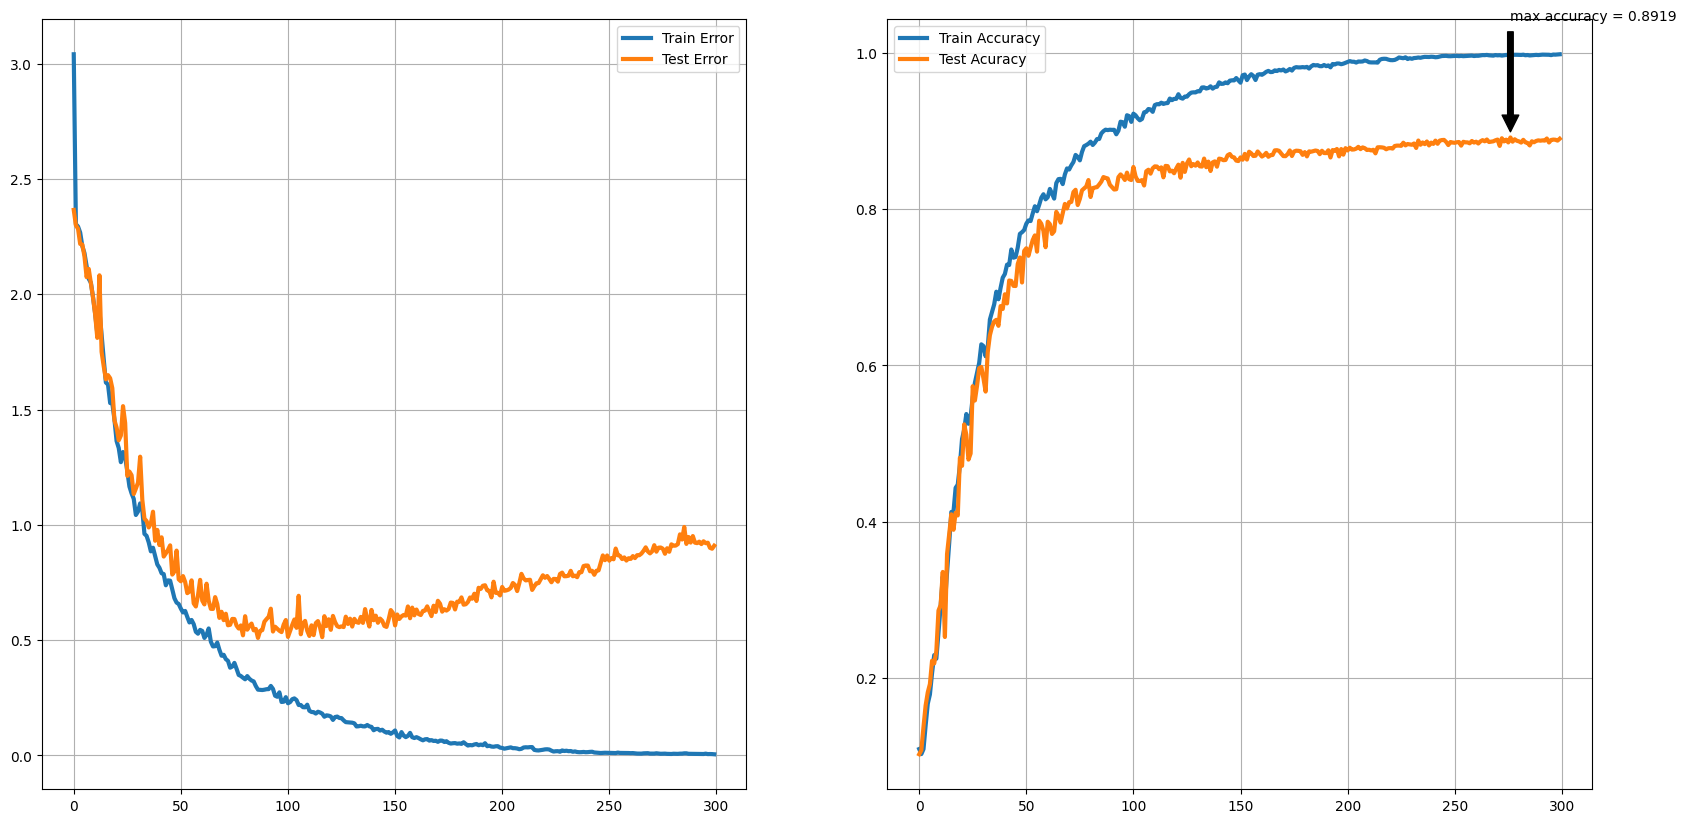

In [ ]:
# Create a figure object with two subplots, with a size of 20 by 10.
f, (fig1, fig2) = plt.subplots(1, 2, figsize=(20, 10))

# Set the number of data points in the training data to n.
n = len(train_loss)

# Plot the training loss and testing loss against the number of epochs on the first subplot.
fig1.plot(range(n), train_loss, '-', linewidth='3', label='Train Error')
fig1.plot(range(n), test_loss, '-', linewidth='3', label='Test Error')

# Plot the training accuracy and testing accuracy against the number of epochs on the second subplot.
fig2.plot(range(n), train_accuracy, '-', linewidth='3', label='Train Accuracy')
fig2.plot(range(n), test_accuracy, '-', linewidth='3', label='Test Acuracy')

# Annotate the maximum accuracy achieved with an arrow on the second subplot.
fig2.annotate('max accuracy = %s'%(ymax), xy=(xmax, ymax), xytext=(xmax, ymax+0.15), arrowprops=dict(facecolor='black', shrink=0.05))

# Turn on the grid lines for both subplots.
fig1.grid(True)
fig2.grid(True)

# Add legends to both subplots.
fig1.legend()
fig2.legend()

# Save the figure to a file named "trainTestCurve.png".
f.savefig("./trainTestCurve.png")

In [ ]:
torch.save(model.state_dict(), '/content/model2.pt')